In [1]:
import imageio

In [2]:
import numpy as np
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches
import imageio.v2 as imageio
from IPython.display import clear_output

map_image = imageio.imread('https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/voronoi-map-goal-16000-shaded.png')
localization = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/localization_2022.csv')

In [3]:
localization.sort_values(['id','t'], inplace=True)

# Pull out observations for the animal we want to track
observations = localization.loc[localization.id==0, ['r','g','b']].values
observations

array([[0.40450578, 0.6301555 , 0.46561281],
       [0.40617818, 0.66695033, 0.42898791],
       [0.45952431, 0.64614036, 0.5104149 ],
       ...,
       [0.26595679, 0.3870192 , 0.58136927],
       [0.23006271, 0.40714405, 0.61864276],
       [0.19856872, 0.37524703, 0.56417422]])

In [4]:
df = localization
W,H = map_image.shape[:2]
M = num_particles = 2000

# Empirical representation of the distribution of X0
δ0 = np.column_stack([np.random.uniform(0,W-1,size=M), np.random.uniform(0,H-1,size=M), np.ones(M)/M])

In [5]:
def patch(im, xy, size=3):
    s = (size-1) / 2
    nx,ny = np.meshgrid(np.arange(-s,s+1), np.arange(-s,s+1))
    nx,ny = np.stack([nx,ny], axis=0).reshape((2,-1))
    neighbourhood = np.row_stack([nx,ny])
    w,h = im.shape[:2]
    neighbours = neighbourhood + np.array(xy).reshape(-1,1)
    neighbours = nx,ny = np.round(neighbours).astype(int)
    nx,ny = neighbours[:, (nx>=0) & (nx<w) & (ny>=0) & (ny<h)]
    patch = im[nx,ny,:3]
    return np.mean(patch, axis=0)/255

In [6]:
localization

id    t           x           y         r         g         b
0      0    0         NaN         NaN  0.404506  0.630156  0.465613
1      0    1         NaN         NaN  0.406178  0.666950  0.428988
2      0    2         NaN         NaN  0.459524  0.646140  0.510415
3      0    3         NaN         NaN  0.614488  0.701871  0.632636
4      0    4         NaN         NaN  0.588620  0.637584  0.534256
...   ..  ...         ...         ...       ...       ...       ...
2495   4  495  181.366177  445.105174  0.183277  0.477103  0.566533
2496   4  496  179.989803  450.649284  0.241684  0.372923  0.616474
2497   4  497  191.065552  454.083354  0.422765  0.641333  0.503985
2498   4  498  191.362526  451.823341  0.481713  0.513194  0.592866
2499   4  499  190.725418  453.078405  0.391682  0.459928  0.474778

[2500 rows x 7 columns]

In [7]:
import torch
locations, color = df.loc[df.id>0,['x','y']].values, df.loc[df.id>0,['r','g','b']].values
y0 = np.array([patch(map_image, loc) for loc in locations])
y0, y = matplotlib.colors.rgb_to_hsv(y0), matplotlib.colors.rgb_to_hsv(color)

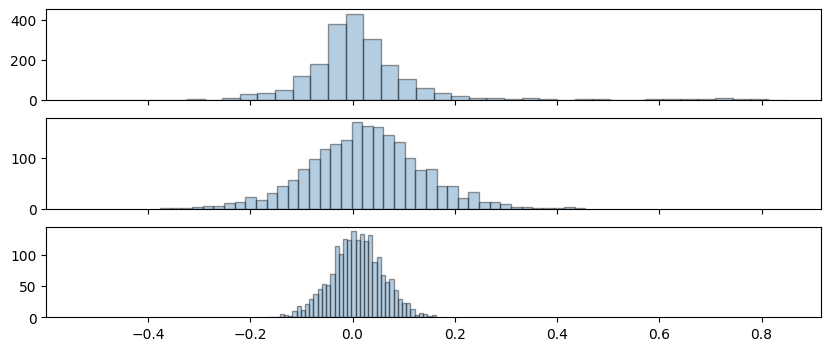

In [8]:
(e0,e1,e2) = np.split(y - y0,3,axis=1)
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,4), sharex=True)
ax1.hist(e0, bins=40, color='steelblue', alpha=.4, ec='black')
ax2.hist(e1, bins=40, color='steelblue', alpha=.4, ec='black')
ax3.hist(e2, bins=40, color='steelblue', alpha=.4, ec='black')
plt.show()

In [9]:
def logPr(x,p):
    (μ,τ) = p
    return np.log(scipy.stats.norm.pdf(x,loc=μ,scale=np.exp(τ)))

ans0 = scipy.optimize.fmin(lambda p: -np.sum(logPr(e0,p)), [0,0])
ans1 = scipy.optimize.fmin(lambda p: -np.sum(logPr(e1,p)), [0,0])
ans2 = scipy.optimize.fmin(lambda p: -np.sum(logPr(e2,p)), [0,0])


Optimization terminated successfully.
         Current function value: -1338.829878
         Iterations: 72
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -1554.909369
         Iterations: 76
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -3130.729208
         Iterations: 77
         Function evaluations: 147


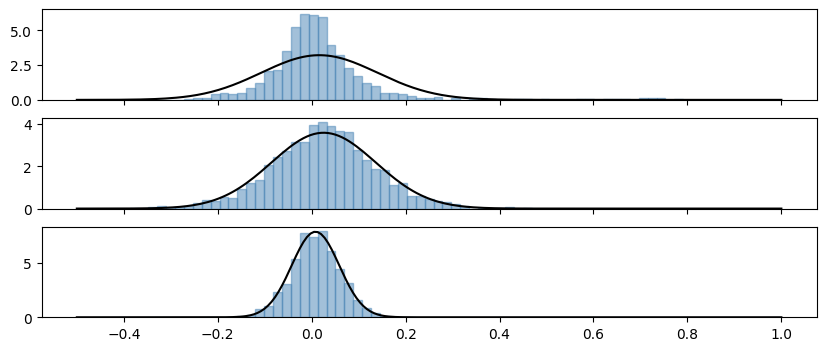

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,4), sharex=True)
x = np.linspace(-0.5,1.0,200)
y = np.exp(logPr(x, ans0))
ax1.plot(x, y, color='black')
ax1.hist(e0, bins = np.linspace(-0.5,1.0,80), density=True, ec='steelblue', fc='steelblue', alpha=.5)

x = np.linspace(-0.5,1.0,200)
y = np.exp(logPr(x, ans1))
ax2.plot(x, y, color='black')
ax2.hist(e1, bins = np.linspace(-0.5,1.0,80), density=True, ec='steelblue', fc='steelblue', alpha=.5)

x = np.linspace(-0.5,1.0,200)
y = np.exp(logPr(x, ans2))
ax3.plot(x, y, color='black')
ax3.hist(e2, bins = np.linspace(-0.5,1.0,80), density=True, ec='steelblue', fc='steelblue', alpha=.5)
plt.show()

In [11]:
def trans(p):
    return [p[0],np.exp(p[1])]

In [12]:
param = [ans0,ans1,ans2]
def pr(y, loc):
    y0,y = matplotlib.colors.rgb_to_hsv([patch(map_image,loc),y])
    e = y - y0
    return np.exp(np.sum([logPr(e[i],param[i]) for i in range(0,3)]))

In [13]:
y0 = observations[0]
loc = δ0[0,:2]
w = pr(y0, loc)
import numbers
assert isinstance(w, numbers.Number) and w>=0

In [14]:
w

0.08323140405958081

In [15]:
y0 = observations[0]
w = np.array([pr(y0, (x,y)) for x,y,_ in δ0])
π0 = np.copy(δ0)
π0[:,2] = w / np.sum(w)

In [16]:
def show_particles(particles, ax=None, s=1, c='red', alpha=.5):
    # Plot an array of particles, with size proportional to weight.
    # (Scale up the sizes by setting s larger.)
    if ax is None:
        fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.imshow(map_image.transpose(1,0,2), alpha=alpha, origin='lower')
    w,h = map_image.shape[:2]
    ax.set_xlim([0,w])
    ax.set_ylim([0,h])
    w = particles[:,2]
    ax.scatter(particles[:,0],particles[:,1], s=w/np.sum(w)*s, color=c)
    ax.axis('off')

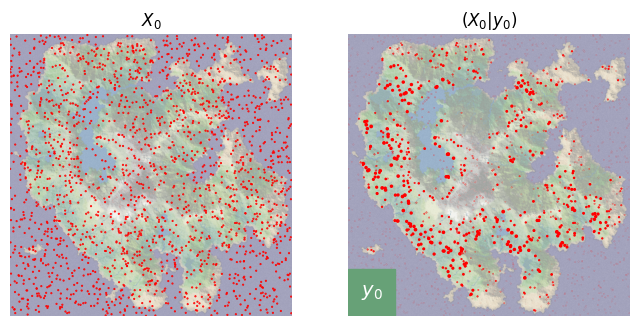

In [17]:
fig,(axδ,axπ) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
show_particles(δ0, ax=axδ, s=600)
show_particles(π0, ax=axπ, s=600)
axπ.add_patch(matplotlib.patches.Rectangle((0,0),100,100,color=y0))
axπ.text(50,50,'$y_0$', c='white', ha='center', va='center', fontsize=14)
axδ.set_title('$X_0$')
axπ.set_title('$(X_0|y_0)$')
plt.show()

In [18]:
diff = []
for i in range(1,len(locations)):
    diff.append(np.linalg.norm(locations[i]-locations[i-1]))
diff = np.mean(diff)
print(f"Average location change between consecutive observations: {diff:.2f}")

def walk(loc):
    # randomly choose a direction in [0, 2π)
    dir = np.random.uniform(0,2*np.pi)
    # randomly choose a distance with mean diff
    dist = np.random.exponential(diff)
    # calculate new location
    new_loc = loc + dist*np.array([np.cos(dir), np.sin(dir)])
    # if new location is outside the map, limit it to the map boundary
    if new_loc[0]<0 or new_loc[0]>W-1 or new_loc[1]<0 or new_loc[1]>H-1:
        new_loc = np.clip(new_loc, 0, [W-1,H-1])
    return new_loc

Average location change between consecutive observations: 4.34


In [19]:
weight_record = np.zeros((200,2000))

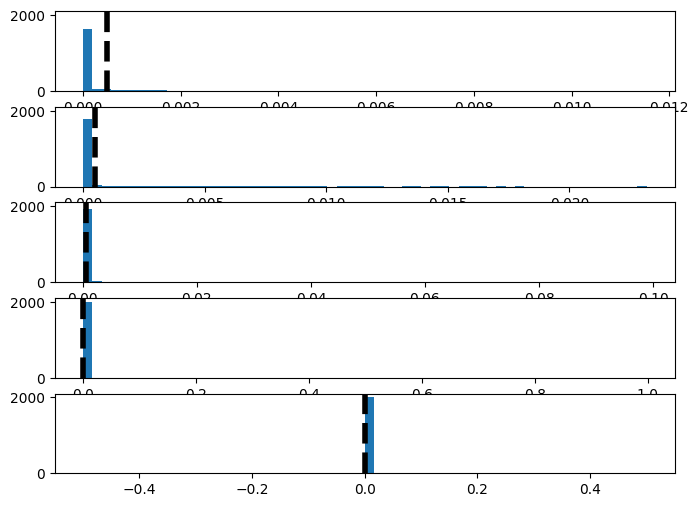

In [20]:
particles = np.copy(π0)
for n,obs in enumerate(observations[:100]):
    for i in range(num_particles):
        particles[i, :2] = walk(particles[i, :2])
    w = particles[:, 2]
    w *= np.array([pr(obs, (px, py)) for px, py, _ in particles])
    particles[:, 2] = w / np.sum(w)
    weight_record[n] = particles[:,2]

fig,axes = plt.subplots(5,1, figsize=(8,6), sharey=True)
for n,ax in zip([0,1,5,50,100],axes):
    w = weight_record[n]
    ax.hist(w, bins=60)
    ax.axvline(x=1/len(particles), color='black', linewidth=4, linestyle='dashed')
plt.show()

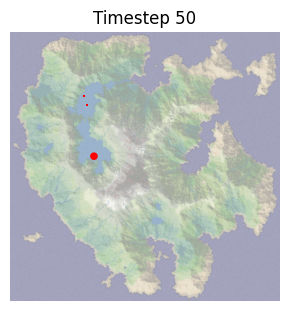

In [53]:
particles = np.copy(π0)

for n,obs in enumerate(observations[:50]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = particles[:,2]
    w *= np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / np.sum(w)

    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)

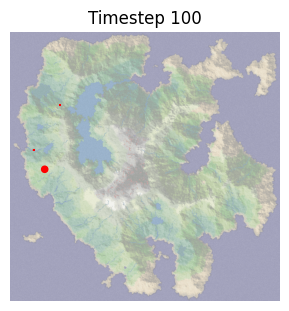

In [55]:
def prune_spawn(particles):
    particles = particles[np.argsort(particles[:,2])]
    l = len(particles)
    for i in range(0, (int)((l + 5) / 5)):
        particles[i] = particles[l - i - 1]
        particles[i][2] /= 2
        particles[l - i - 1][2] /= 2
    return particles


particles = np.copy(π0)

for n,obs in enumerate(observations[:100]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = particles[:,2]
    w *= np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / np.sum(w)
    # Prune/spawn
    prune_spawn(particles)

    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)